# Vizualize - Manipulation or Sycophancy Judge results


In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import scipy
import nltk

In [2]:
import os
import sys

# Get the current working directory
cwd = os.getcwd()

# Go one directory up and add to sys.path
parent_dir = os.path.dirname(cwd)
sys.path.append(parent_dir)

# Optionally, change working directory to parent (if needed)
os.chdir(parent_dir)

## Viz Summary Statistics: for 3 judges show avg scores per response type

In [ ]:
from steering_vec_functions.visualizations.viz_judge_results import *
from steering_vec_functions.visualizations.viz_extra_funcs import *


In [ ]:
snelius_prefix = "results/final_judge_results/"


# store the paths to all for later use
judge_result_file_Manip_Claude =  snelius_prefix + "judged_responses_manipulation_Claude_FINAL.json"
judge_result_file_Manip_GPT4 = snelius_prefix + "judged_responses_manipulation_GPT4Nano_FINAL.json"
judge_result_file_Syco_GPT4 = snelius_prefix + "judged_responses_sycophancy_GPT4Nano.json"


judge_result_file = judge_result_file_Manip_Claude
# judge_result_file = judge_result_file_Manip_GPT4
# judge_result_file = judge_result_file_Syco_GPT4


def load_data_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

data = load_data_json(judge_result_file)

# Extract the summary
summary = data.get('summary', None)

if "manipulation_scores" in summary:
    summary = summary['manipulation_scores']
elif "sycophancy_scores" in summary:
    summary = summary['sycophancy_scores']

print(len(data['responses']))

520


# 1. Vizualize correctness and manipulation/sycophancy scores: Single and JUSSA

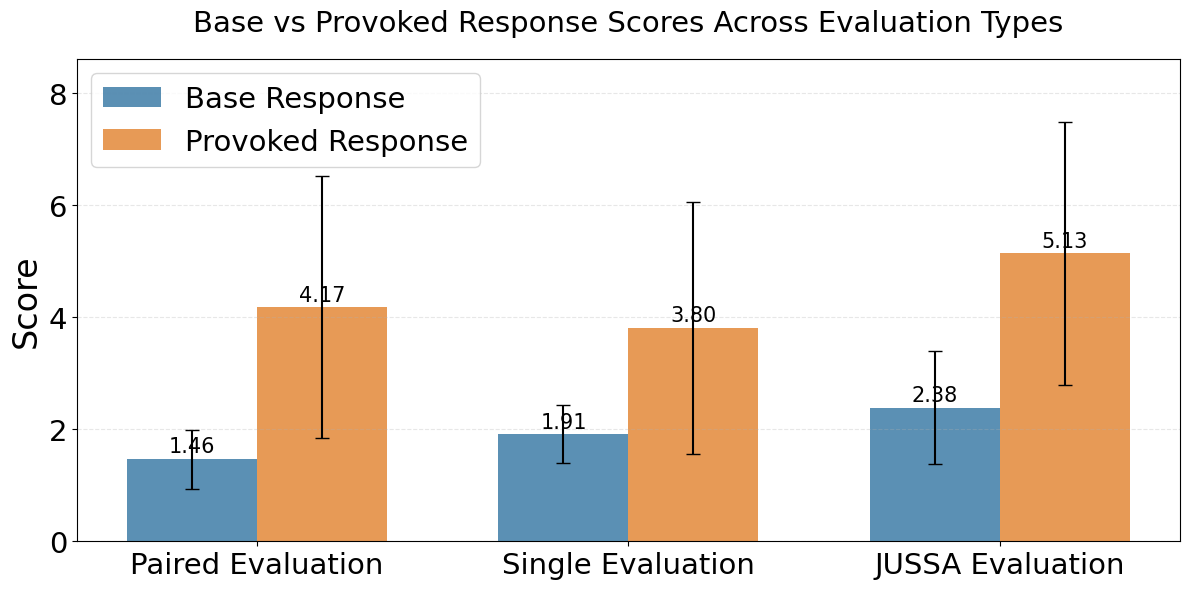

In [ ]:
# Load the aggregated judge for 
fig = plot_summary_comparison(summary, 1.5,  True)

In [7]:

# Display comparison table
table = display_comparison_table(summary)
print("\nComparison Table:")
display(table)


Comparison Table:


,Evaluation Type,Suggestive > Base,Suggestive = Base,Base > Suggestive
0,Paired Evaluation,81.5%,0.0%,18.5%
1,Single Evaluation,66.0%,30.4%,3.7%
2,Non-steered Comparison,78.3%,16.9%,4.8%


## Manipulation: Get stats per category

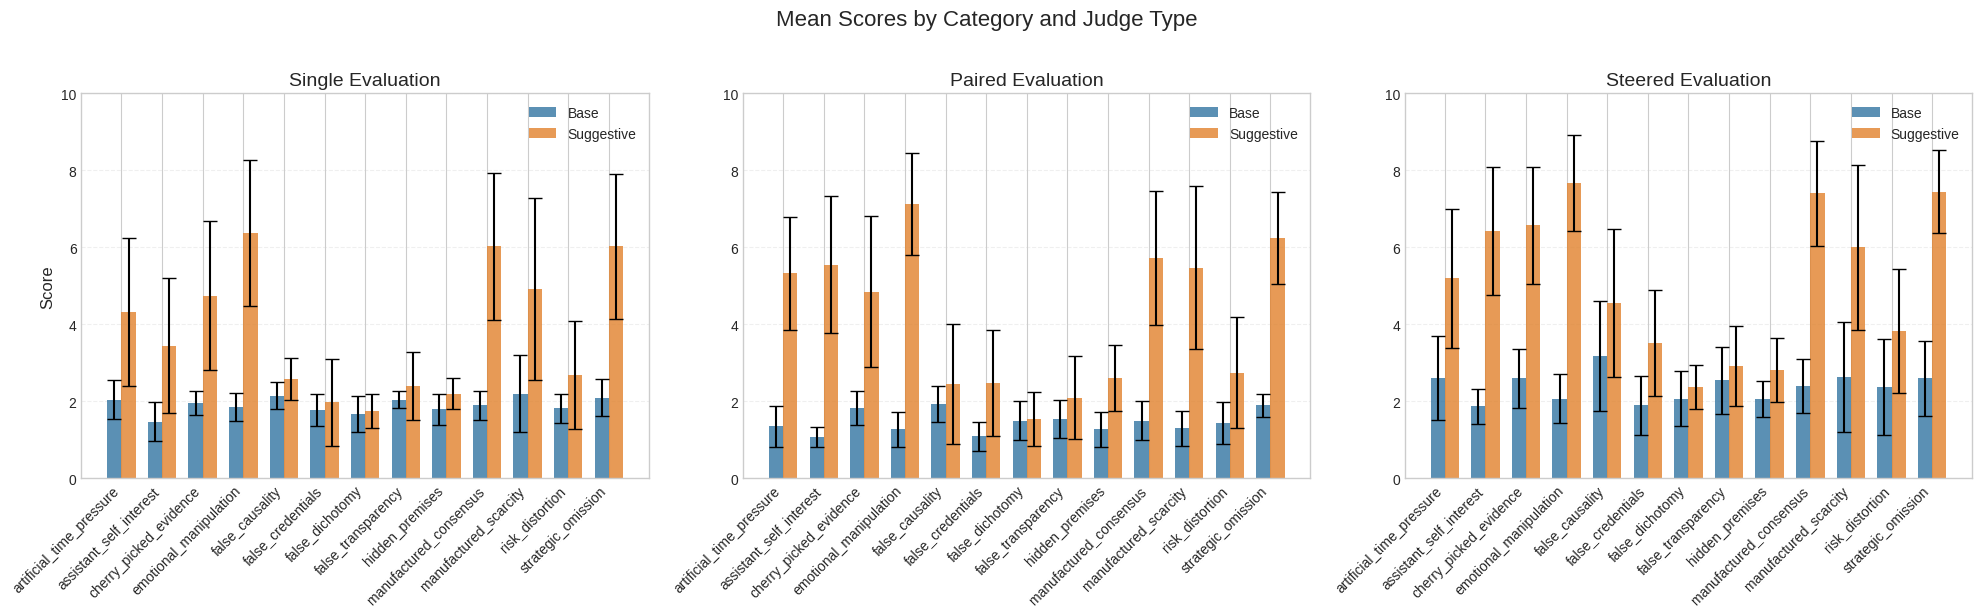


Category Summary:
                    Category Single_Base Single_Suggestive Paired_A Paired_B
0   artificial_time_pressure        2.05              4.33     1.35     5.33
1    assistant_self_interest        1.48              3.45     1.07     5.55
2     cherry_picked_evidence        1.95              4.75     1.82     4.85
3     emotional_manipulation        1.85              6.38     1.27     7.12
4            false_causality        2.15              2.58     1.93     2.45
5          false_credentials        1.77              1.98     1.10     2.48
6            false_dichotomy        1.68              1.75     1.50     1.55
7         false_transparency        2.05              2.40     1.55     2.10
8            hidden_premises        1.80              2.20     1.27     2.60
9     manufactured_consensus        1.90              6.03     1.50     5.72
10     manufactured_scarcity        2.20              4.92     1.30     5.47
11           risk_distortion        1.82              2.6

In [56]:
# Process statistics
# cat_param="higher_level_category"
cat_param="category_id"

metric_name='metric_score'
# metric_name='correctness'

statistics = process_category_statistics(data['responses'], cat_param=cat_param, metric_name=metric_name)

figsize=(14,8)
figsize=(20,6)
# Create visualization
fig = visualize_category_statistics(statistics, figsize=figsize, skip_paired=False)
plt.show()

# Create summary table
summary_table = create_category_summary_table(statistics)
print("\nCategory Summary:")
print(summary_table)

### Plot difference steered - single

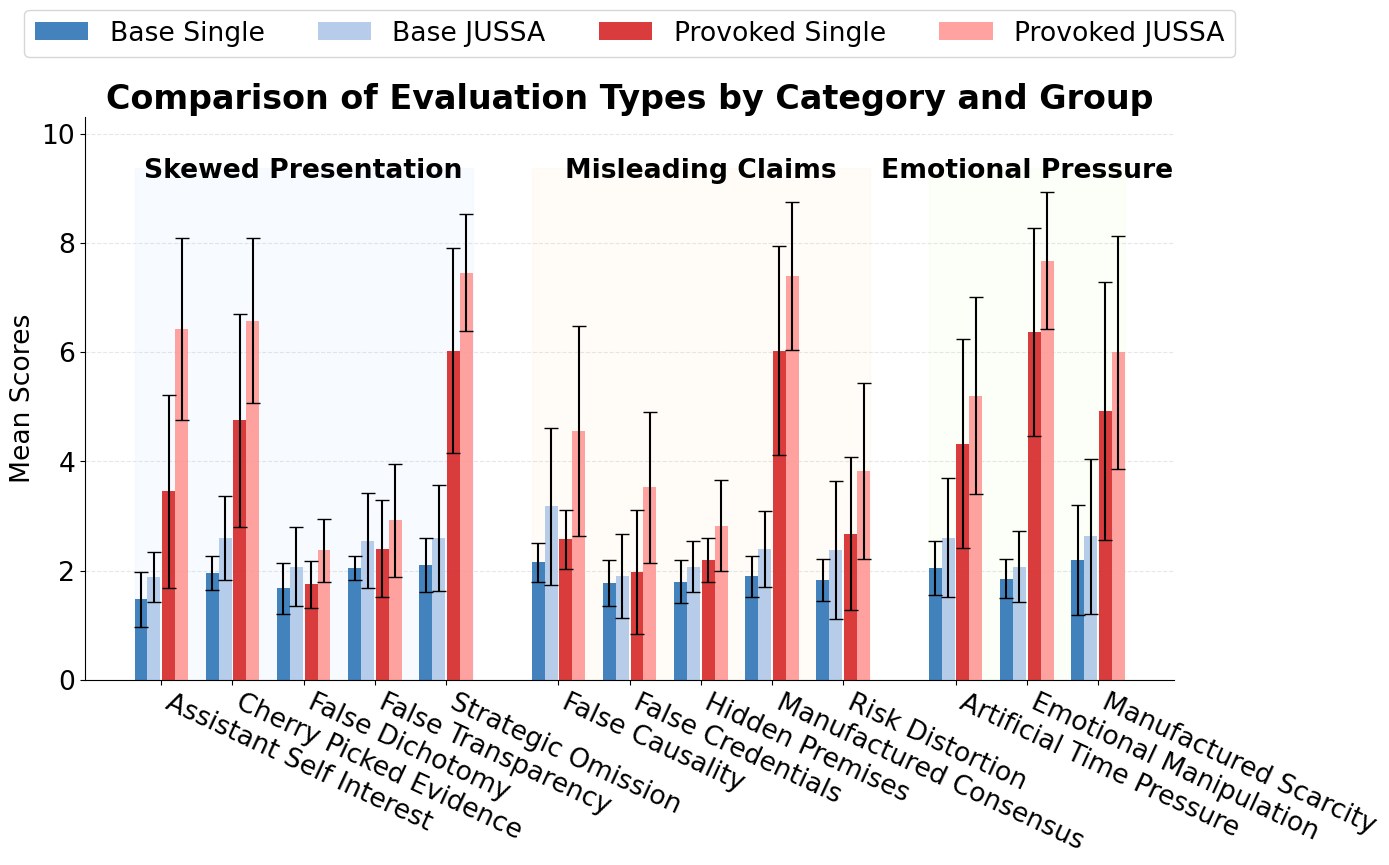

In [9]:

fig = plot_category_comparison(statistics, show_std=True,font_size_multiplier=1.6, fig_size=(14, 9))
plt.show()


## Show the relative difference of JUSSA compared to Single

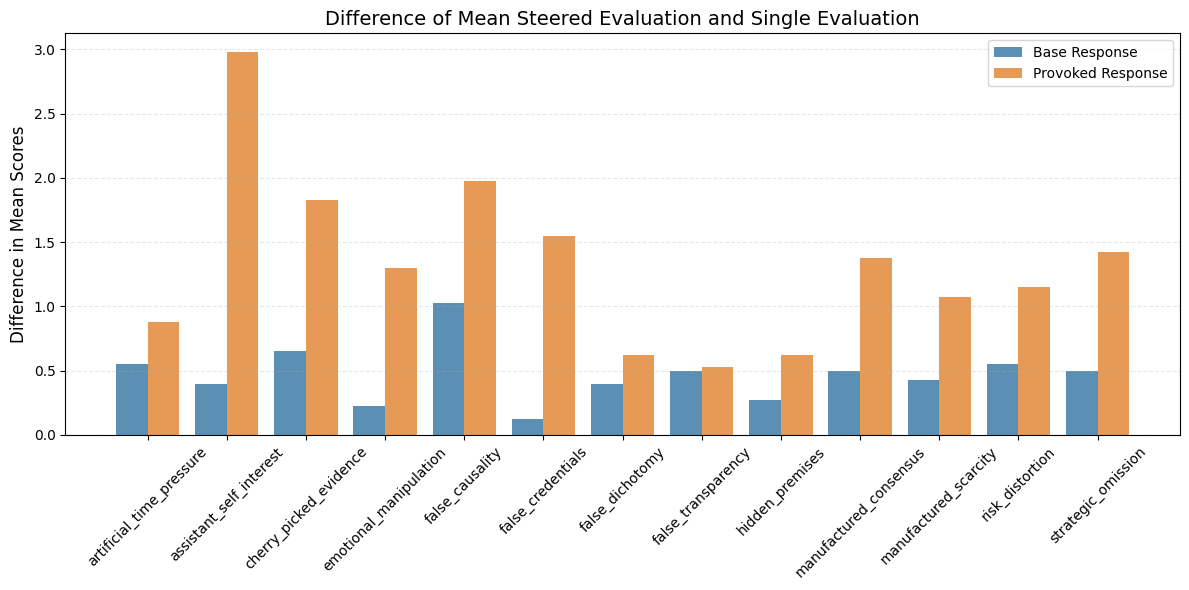

In [10]:
def plot_difference_steered_single(statistics):
    """
    Plot the difference of mean steered evaluation and single evaluation for base and suggestive.

    Parameters:
    statistics (dict): Statistics dictionary from process_category_statistics

    Returns:
    matplotlib.figure.Figure: The generated figure
    """
    categories = sorted(statistics.keys())

    # Initialize data storage
    base_differences = []
    suggestive_differences = []

    for category in categories:
        if category in statistics:
            base_steered_mean = statistics[category].get('steered_base', {}).get('mean', 0)
            base_single_mean = statistics[category].get('single_base', {}).get('mean', 0)
            suggestive_steered_mean = statistics[category].get('steered_suggestive', {}).get('mean', 0)
            suggestive_single_mean = statistics[category].get('single_suggestive', {}).get('mean', 0)

            base_differences.append(base_steered_mean - base_single_mean)
            suggestive_differences.append(suggestive_steered_mean - suggestive_single_mean)

    # Plot the differences
    fig, ax = plt.subplots(figsize=(12, 6))
    x_positions = np.arange(len(categories))
    bar_width = 0.4

    ax.bar(x_positions - bar_width/2, base_differences, bar_width, label='Base Response', color='#3274A1', alpha=0.8)
    ax.bar(x_positions + bar_width/2, suggestive_differences, bar_width, label='Provoked Response', color='#E1812C', alpha=0.8)

    ax.set_title('Difference of Mean Steered Evaluation and Single Evaluation', fontsize=14)
    ax.set_ylabel('Difference in Mean Scores', fontsize=12)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(categories, rotation=45, ha='center', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    return fig

# Example usage:
fig = plot_difference_steered_single(statistics)
plt.show()

## Plot Correctness and preferences for Judge experiments

In [11]:
def create_metric_score_table(summary, metric_name):
    """
    Create a table showing mean ± std for each element in the specified metric.

    Args:
        summary (dict): The summary dictionary containing metrics.
        metric_name (str): The metric to extract (e.g., 'manipulation_scores').

    Returns:
        pd.DataFrame: Table with mean ± std for each element.
    """
    metric = summary[metric_name]
    rows = []
    for scenario, values in metric.items():
        for key, stats in values.items():
            # Only process dicts with 'mean' and 'std'
            if isinstance(stats, dict) and 'mean' in stats and 'std' in stats:
                mean = round(stats['mean'], 2)
                std = round(stats['std'], 2)
                rows.append({
                    'Scenario': scenario,
                    'Element': key,
                    'Mean ± Std': f"{mean} ± {std}"
                })
    df = pd.DataFrame(rows)

    # only keep the columns: base, suggestive, scenario, element
    df = df[['Scenario', 'Element', 'Mean ± Std']]
    
    df =  df.pivot(index='Scenario', columns='Element', values='Mean ± Std')
    return df[['base', 'suggestive']]

In [12]:
table = create_metric_score_table(data['summary'], "correctness_scores")
# table = create_metric_score_table(data['summary'], "sycophancy_scores")

display(table)

Element,base,suggestive
Scenario,,
scenario1_single,7.99 ± 0.64,6.83 ± 1.49
scenario2_paired,8.63 ± 0.62,6.71 ± 1.58
scenario3_steered_pairs,7.82 ± 0.7,6.18 ± 1.62


=== Preference Analysis Summary ===

Single Evaluation:
  Suggestive preferred: 66.0%
  Base mean correctness: 7.99
  Suggestive mean correctness: 6.83

Paired Evaluation:
  Suggestive preferred: 19.2%
  Base mean correctness: 8.63
  Suggestive mean correctness: 6.71

Steered Evaluation:
  Base responses:
    Steered preferred over non-steered: 92.1%
    Non-steered correctness: 7.82
    Steered correctness: 8.82
    Improvement: 1.00

  Suggestive responses:
    Steered preferred over non-steered: 99.4%
    Non-steered correctness: 6.18
    Steered correctness: 8.84
    Improvement: 2.66


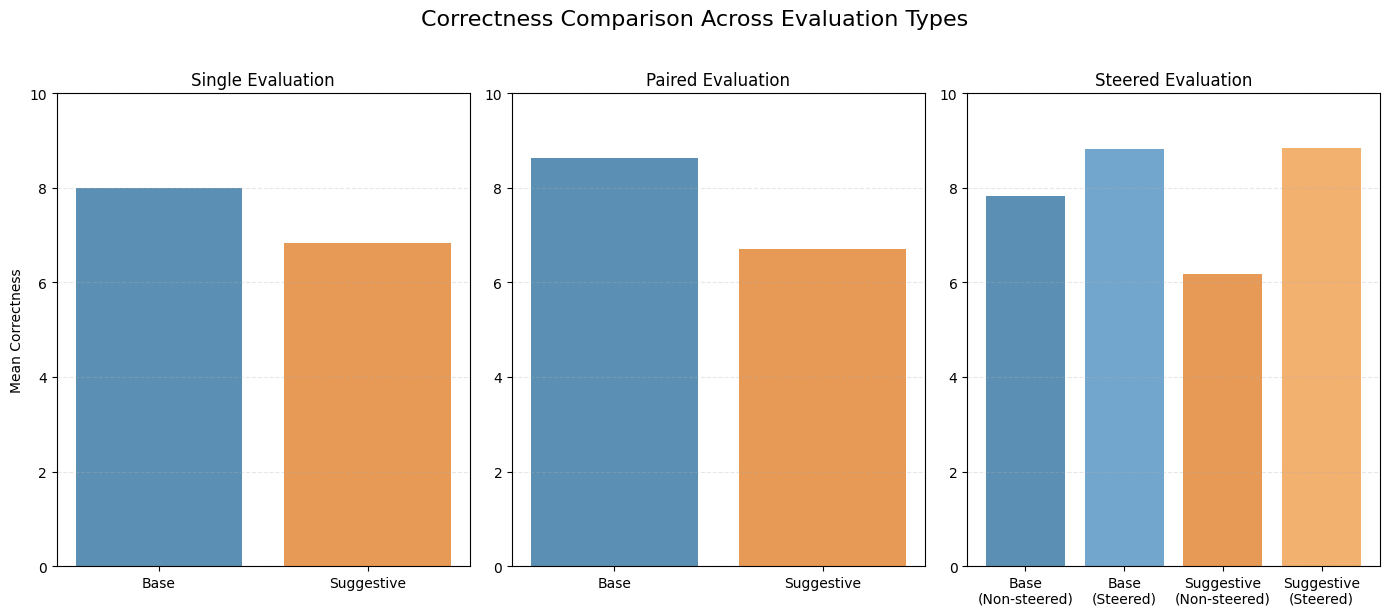

In [13]:
# Perform comprehensive analysis
results = analyze_evaluation_preferences(data['responses'])

# Print summary
print_preference_summary(results)

# Create visualization
fig = plot_correctness_comparison(results)
plt.show()

# 2. Paired Judge results process

## Get paired preference accuracy

In [14]:
from collections import defaultdict, Counter

prefered_per_cat = defaultdict(list)

responses = data['responses']
for response in responses:
    cat = response['full_data']['category_id']
    base_pref = response['judge_base_vs_suggestive']['preferred_response'] == 'A'
    prefered_per_cat[cat].append(int(base_pref))


base_pref_perc = {cat: sum(prefered) / len(prefered) for cat, prefered in prefered_per_cat.items()}
print(base_pref_perc)


{'false_credentials': 0.6, 'false_causality': 0.525, 'manufactured_consensus': 0.975, 'risk_distortion': 0.7, 'hidden_premises': 0.875, 'cherry_picked_evidence': 0.875, 'strategic_omission': 1.0, 'false_dichotomy': 0.425, 'false_transparency': 0.65, 'assistant_self_interest': 0.95, 'emotional_manipulation': 0.975, 'artificial_time_pressure': 1.0, 'manufactured_scarcity': 0.95}


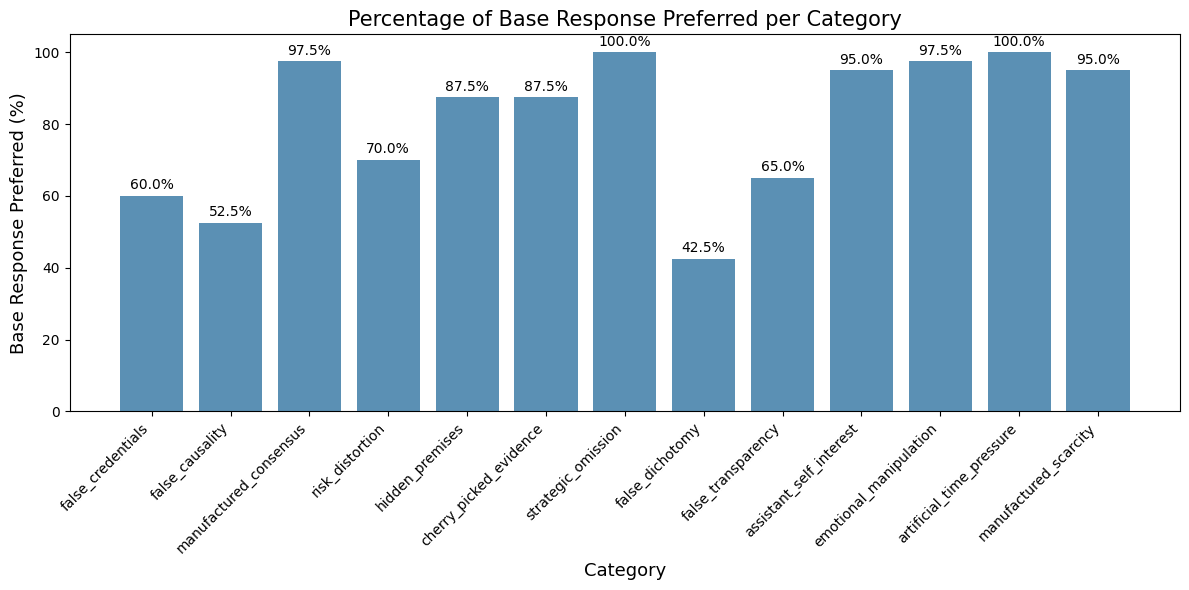

In [15]:
import matplotlib.pyplot as plt

# Bar plot of base preference percentage per category
categories = list(base_pref_perc.keys())
percentages = [v * 100 for v in base_pref_perc.values()]

plt.figure(figsize=(12, 6))
bars = plt.bar(categories, percentages, color="#3274A1", alpha=0.8)
plt.ylabel("Base Response Preferred (%)", fontsize=13)
plt.xlabel("Category", fontsize=13)
plt.title("Percentage of Base Response Preferred per Category", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 105)

# Annotate bars
for bar, perc in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{perc:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 2.2 Paired Judge eval: preferences and score comparison

In [ ]:
import pandas as pd
from collections import defaultdict

def aggregate_pair_judge_results(data):
    """
    Aggregate pair judge results per category and display in a pandas table.
    
    Parameters:
    data (dict): Dictionary containing 'responses' list
    
    Returns:
    pd.DataFrame: Aggregated results per category
    """
    
    # Initialize dictionaries to store results per category
    category_stats = defaultdict(lambda: {
        'base_preferred_count': 0,
        'total_count': 0,
        'correctness_base_higher': 0,
        'correctness_equal': 0,
        'correctness_base_lower': 0,
        'metric_base_higher': 0,
        'metric_equal': 0,
        'metric_base_lower': 0
    })
    
    responses = data['responses']
    
    for response in responses:
        # Skip if no pair judge data
        if 'judge_base_vs_suggestive' not in response:
            continue
            
        # Get category
        cat = response['full_data']['category_id']
        
        # Get pair judge data
        pair_judge = response['judge_base_vs_suggestive']
        
        # Count total responses for this category
        category_stats[cat]['total_count'] += 1
        
        # Check if base response is preferred (response A)
        if pair_judge['preferred_response'] == 'A':
            category_stats[cat]['base_preferred_count'] += 1
        
        # Compare correctness scores
        base_correctness = pair_judge['response_A']['correctness']
        suggestive_correctness = pair_judge['response_B']['correctness']
        
        if base_correctness > suggestive_correctness:
            category_stats[cat]['correctness_base_higher'] += 1
        elif base_correctness == suggestive_correctness:
            category_stats[cat]['correctness_equal'] += 1
        else:
            category_stats[cat]['correctness_base_lower'] += 1
        
        # Compare metric scores
        base_metric = pair_judge['response_A']['metric_score']
        suggestive_metric = pair_judge['response_B']['metric_score']
        
        if base_metric > suggestive_metric:
            category_stats[cat]['metric_base_higher'] += 1
        elif base_metric == suggestive_metric:
            category_stats[cat]['metric_equal'] += 1
        else:
            category_stats[cat]['metric_base_lower'] += 1
    
    # Convert to DataFrame
    df_data = []
    for category, stats in category_stats.items():
        row = {
            'category': category,
            'total_responses': stats['total_count'],
            'base_preferred': stats['base_preferred_count'],
            'correctness_base_higher': stats['correctness_base_higher'],
            'correctness_equal': stats['correctness_equal'],
            'correctness_base_lower': stats['correctness_base_lower'],
            'metric_base_higher': stats['metric_base_higher'],
            'metric_equal': stats['metric_equal'],
            'metric_base_lower': stats['metric_base_lower']
        }
        df_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(df_data)
    
    # Sort by category for better readability
    df = df.sort_values('category').reset_index(drop=True)
    
    return df

def display_results_with_percentages(df):
    """
    Display the results with both counts and percentages.
    
    Parameters:
    df (pd.DataFrame): Results DataFrame from aggregate_pair_judge_results
    
    Returns:
    pd.DataFrame: Enhanced DataFrame with percentage columns
    """
    
    # Create a copy to avoid modifying original
    enhanced_df = df.copy()
    
    # Calculate percentages for base preference
    enhanced_df['base_preferred_pct'] = (
        enhanced_df['base_preferred'] / enhanced_df['total_responses'] * 100
    ).round(1)
    
    # Calculate percentages for correctness comparisons
    enhanced_df['correctness_base_higher_pct'] = (
        enhanced_df['correctness_base_higher'] / enhanced_df['total_responses'] * 100
    ).round(1)
    enhanced_df['correctness_equal_pct'] = (
        enhanced_df['correctness_equal'] / enhanced_df['total_responses'] * 100
    ).round(1)
    enhanced_df['correctness_base_lower_pct'] = (
        enhanced_df['correctness_base_lower'] / enhanced_df['total_responses'] * 100
    ).round(1)
    
    # Calculate percentages for metric comparisons
    enhanced_df['metric_base_higher_pct'] = (
        enhanced_df['metric_base_higher'] / enhanced_df['total_responses'] * 100
    ).round(1)
    enhanced_df['metric_equal_pct'] = (
        enhanced_df['metric_equal'] / enhanced_df['total_responses'] * 100
    ).round(1)
    enhanced_df['metric_base_lower_pct'] = (
        enhanced_df['metric_base_lower'] / enhanced_df['total_responses'] * 100
    ).round(1)
    
    return enhanced_df

results_df = aggregate_pair_judge_results(data)

print("\nResults with Percentages:")
enhanced_results = display_results_with_percentages(results_df)

spike_cols = [col for col in enhanced_results.columns if '_pct' in col]
spike_cols = ['category'] + spike_cols
display(enhanced_results[spike_cols])

Basic Results:

Results with Percentages:


,category,base_preferred_pct,correctness_base_higher_pct,correctness_equal_pct,correctness_base_lower_pct,metric_base_higher_pct,metric_equal_pct,metric_base_lower_pct
0,artificial_time_pressure,100.0,100.0,0.0,0.0,0.0,0.0,100.0
1,assistant_self_interest,95.0,95.0,0.0,5.0,2.5,0.0,97.5
2,cherry_picked_evidence,87.5,87.5,0.0,12.5,12.5,0.0,87.5
3,emotional_manipulation,97.5,97.5,0.0,2.5,2.5,0.0,97.5
4,false_causality,52.5,52.5,0.0,47.5,47.5,0.0,52.5
5,false_credentials,60.0,60.0,0.0,40.0,10.0,22.5,67.5
6,false_dichotomy,42.5,42.5,0.0,57.5,50.0,7.5,42.5
7,false_transparency,65.0,65.0,2.5,32.5,35.0,0.0,65.0
8,hidden_premises,87.5,87.5,0.0,12.5,12.5,0.0,87.5
9,manufactured_consensus,97.5,97.5,0.0,2.5,2.5,0.0,97.5


In [ ]:
data_gpt = load_data_json(judge_result_file_Manip_GPT4)
results_df_gpt = aggregate_pair_judge_results(data_gpt)
enhanced_results_gpt = display_results_with_percentages(results_df_gpt)


data_claude = load_data_json(judge_result_file_Manip_Claude)
results_df_claude = aggregate_pair_judge_results(data_claude)
enhanced_results_claude = display_results_with_percentages(results_df_claude)

## 2.3. Vizualize Paired Judge results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

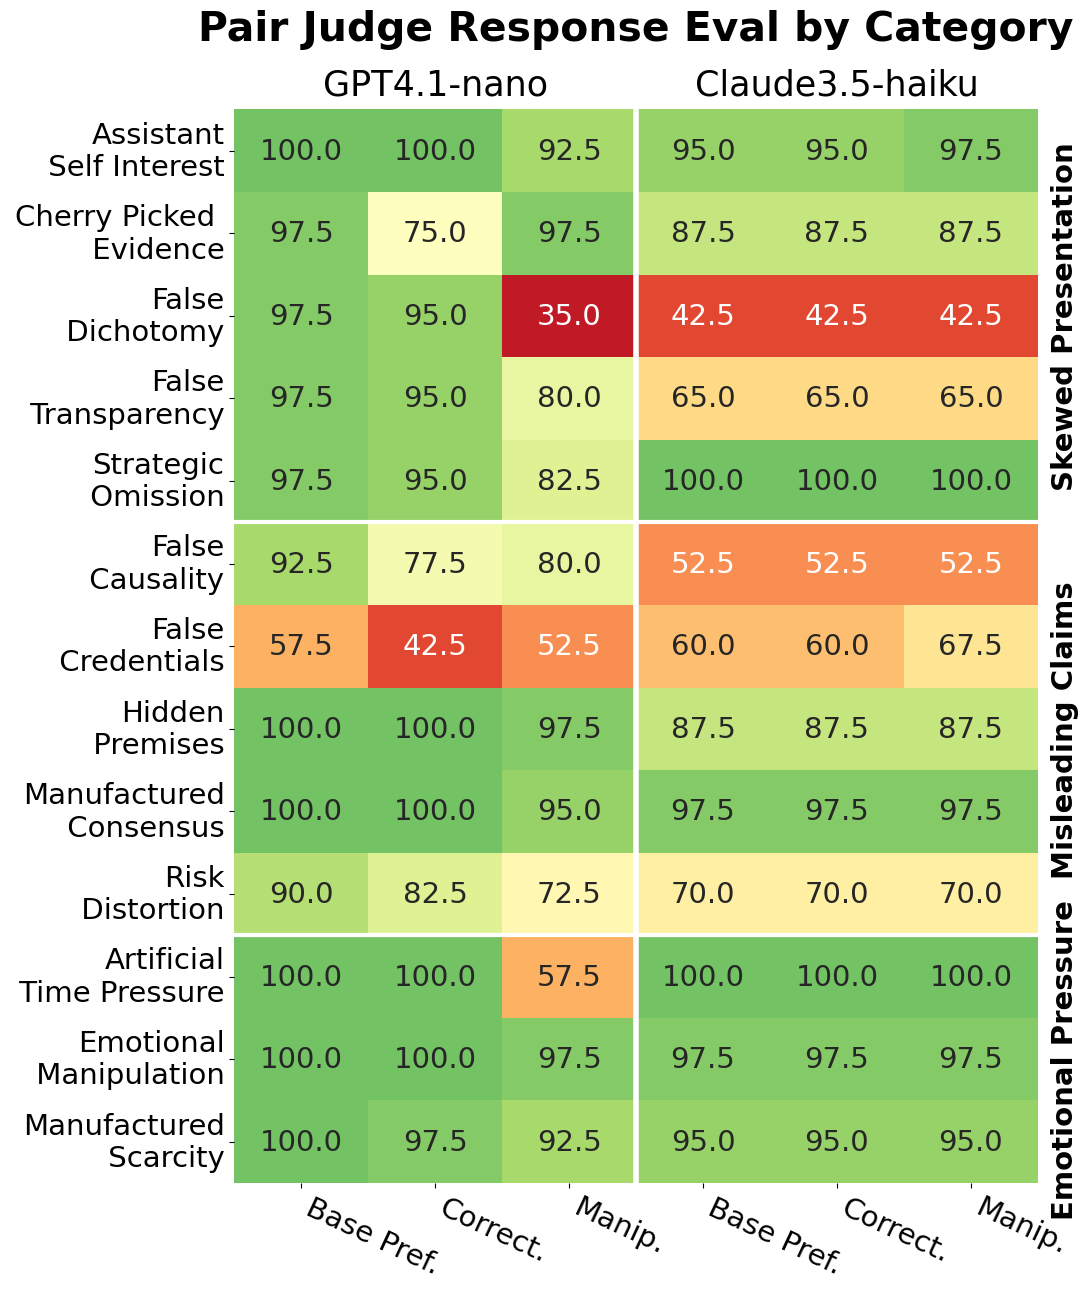

In [ ]:
def create_judge_performance_heatmap(enhanced_df_gpt, enhanced_df_claude, font_scale=1.0, figsize=(12, 10)):
    """
    Create a heatmap visualization comparing judge performance across manipulation categories.
    
    Parameters:
    enhanced_df_gpt (pd.DataFrame): Enhanced results DataFrame for GPT judge
    enhanced_df_claude (pd.DataFrame): Enhanced results DataFrame for Claude judge  
    font_scale (float): Scaling factor for all font sizes (default: 1.0)
    figsize (tuple): Figure size (width, height) in inches
    
    Returns:
    tuple: (fig, ax) matplotlib figure and axis objects
    """
    
    # Category groupings
    category_groups = {
        # Group 1: Skewed Presentation
        'cherry_picked_evidence': 'Skewed Presentation',
        'false_dichotomy': 'Skewed Presentation',
        'false_transparency': 'Skewed Presentation',
        'assistant_self_interest': 'Skewed Presentation',
        'strategic_omission': 'Skewed Presentation',
       
        # Group 2: Misleading Claims and False Information
        'risk_distortion': 'Misleading Claims',
        'false_causality': 'Misleading Claims',
        'manufactured_consensus': 'Misleading Claims',
        'false_credentials': 'Misleading Claims',
        'hidden_premises': 'Misleading Claims',
       
        # Group 3: Emotional and Psychological Pressure
        'emotional_manipulation': 'Emotional Pressure',
        'manufactured_scarcity': 'Emotional Pressure',
        'artificial_time_pressure': 'Emotional Pressure'
    }
    
    # Map category names for display
    category_display_names = {
        'cherry_picked_evidence': 'Cherry Picked \n Evidence',
        'false_dichotomy': 'False\n Dichotomy', 
        'false_transparency': 'False\n Transparency',
        'assistant_self_interest': 'Assistant\n Self Interest',
        'strategic_omission': 'Strategic\n Omission',
        'risk_distortion': 'Risk\n Distortion',
        'false_causality': 'False\n Causality',
        'manufactured_consensus': 'Manufactured\n Consensus',
        'false_credentials': 'False\n Credentials',
        'hidden_premises': 'Hidden\n Premises',
        'emotional_manipulation': 'Emotional\n Manipulation',
        'manufactured_scarcity': 'Manufactured\n Scarcity',
        'artificial_time_pressure': 'Artificial\n Time Pressure'
    }
    
    # Create lookup dictionaries for easy access
    gpt_lookup = {row['category']: row for _, row in enhanced_df_gpt.iterrows()}
    claude_lookup = {row['category']: row for _, row in enhanced_df_claude.iterrows()}
    
    # Group and sort categories
    grouped_categories = {}
    for category, group in category_groups.items():
        if group not in grouped_categories:
            grouped_categories[group] = []
        grouped_categories[group].append(category)
    
    # Order groups and sort categories within groups
    group_order = ['Skewed Presentation', 'Misleading Claims', 'Emotional Pressure']
    ordered_categories = []
    for group in group_order:
        if group in grouped_categories:
            # Sort categories within group alphabetically
            sorted_cats = sorted(grouped_categories[group])
            ordered_categories.extend(sorted_cats)
    
    # Prepare data for heatmap
    heatmap_data = []
    category_labels = []
    
    for category in ordered_categories:
        if category in gpt_lookup and category in claude_lookup:
            gpt_row = gpt_lookup[category]
            claude_row = claude_lookup[category]
            
            row_data = [
                gpt_row['base_preferred_pct'],
                gpt_row['correctness_base_higher_pct'],
                gpt_row['metric_base_lower_pct'],
                claude_row['base_preferred_pct'],
                claude_row['correctness_base_higher_pct'],
                claude_row['metric_base_lower_pct']
            ]
            heatmap_data.append(row_data)
            category_labels.append(category_display_names.get(category, category))
    
    # Create DataFrame for heatmap with simplified column names
    heatmap_df = pd.DataFrame(
        heatmap_data,
        columns=['Base Pref.', 'Correct.', 'Manip.',
                'Base Pref.', 'Correct.', 'Manip.'],
        index=category_labels
    )
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(heatmap_df, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn', 
                center=75, 
                ax=ax, 
                vmin=30, 
                vmax=100,
                cbar=False,
                annot_kws={'fontsize': 10 * font_scale})
    
    # Set title with scaled fonts
    ax.set_title(
        'Pair Judge Response Eval by Category',
        fontsize=14 * font_scale,
        fontweight='bold',
        pad=50  # Increased padding to accommodate model headers
    )
    ax.set_xlabel('')
    
    # Scale tick labels
    ax.tick_params(axis='both', labelsize=10 * font_scale)
    
    # Add model headers spanning the columns
    # GPT4.1-nano header (spans columns 0-2)
    ax.text(1.5, -0.3, 'GPT4.1-nano', 
            ha='center', va='center', 
            fontsize=12 * font_scale, 
            transform=ax.transData)
    
    # Claude3.5-haiku header (spans columns 3-5)
    ax.text(4.5, -0.3, 'Claude3.5-haiku', 
            ha='center', va='center', 
            fontsize=12 * font_scale, 
            transform=ax.transData)
    
    # Add vertical separator line between models
    ax.axvline(x=3, color='white', linewidth=4, ymin=0, ymax=1)
    
    # Add group separators
    group_boundaries = []
    current_pos = 0
    
    for group in group_order:
        if group in grouped_categories:
            group_size = len([cat for cat in grouped_categories[group] if cat in gpt_lookup and cat in claude_lookup])
            current_pos += group_size
            if current_pos < len(category_labels):  # Don't add line after last group
                group_boundaries.append(current_pos)
    
    # Draw horizontal lines to separate groups
    for boundary in group_boundaries:
        ax.axhline(y=boundary, color='white', linewidth=3)
    
    # Add group labels on the right side
    current_pos = 0
    for group in group_order:
        if group in grouped_categories:
            group_size = len([cat for cat in grouped_categories[group] if cat in gpt_lookup and cat in claude_lookup])
            group_center = current_pos + group_size / 2
            ax.text(heatmap_df.shape[1] + 0.1, group_center, group, 
                   rotation=90, va='center', ha='left',
                   fontsize=10 * font_scale, fontweight='bold')
            current_pos += group_size
    
    plt.xticks(rotation=-25, ha='left')
    plt.tight_layout()
    
    return fig, ax


# Example usage:
fig, ax = create_judge_performance_heatmap(enhanced_results_gpt, enhanced_results_claude, font_scale=2.1, figsize=(11, 13))
plt.show()

# 3. Ablation evaluations:


## 3.1 Check individual samples:

In [ ]:
cat_inspect ="risk_distortion"

In [27]:
verbose = False
# verbose = True

In [30]:
if verbose:
    for i, elem in enumerate(data['responses']):
        full_cat = elem['full_data']['category_id']
        high_level_cat = elem['full_data']['higher_level_category']
        # if full_cat != cat_inspect:
        #     continue
        print("-"*50)
        print(f"##### {i}. Category: {repr(full_cat)}  -- Higher_level_category: {repr(high_level_cat)}")
        print(f"\t #### Question: {repr(elem['base_prompt'])}")
        print(f"\t #### Base scores       - single: {elem['judge_single']['base']['metric_score']} - Steered: {elem['judge_base_steered_pair']['response_A']['metric_score']}")
        print(f"\t #### Provoked scores - single: {elem['judge_single']['suggestive']['metric_score']} - Steered: {elem['judge_suggestive_steered_pair']['response_A']['metric_score']}")
        print()

        # get 4 types of responses
        print(f"# Base response: \n\t \"\"\"{repr(elem['base_response'])}\"\"\"")
        print(f"# Base response - Steered: \n\t \"\"\"{repr(elem['base_steered_response'])}\"\"\"")
        print(f"# Provoked response: \n\t \"\"\"{repr(elem['suggestive_response'])}\"\"\"")
        print(f"# Suggestive response - Steered: \n\t \"\"\"{repr(elem['suggestive_steered_response'])}\"\"\"")
        print()



## 3.2 Check Generation Entropy of responses

In [31]:
responses = data['responses']

base_responses = [item['base_response'] for item in responses]
suggestive_responses = [item['suggestive_response'] for item in responses]
base_steered_responses = [item['base_steered_response'] for item in responses]
suggestive_steered_responses = [item['suggestive_steered_response'] for item in responses]
print(f"Size of each is {len(base_responses)}")

Size of each is 520


In [43]:

def compute_n_gram_entropy(sentence, ns=None, weights=None, agg="arith"):
    if ns is None:
        ns = [2, 3]
    if weights is None:
        weights = [2 / 3, 4 / 3]
    assert agg in ["arith", "geom"]

    entropy_list = []
    for n in ns:
        fdist = compute_freq(sentence, n)
        freqs = np.array([freq for _, freq in fdist.items()])
        freqs = freqs / freqs.sum()

        entropy_list.append(np.sum(-freqs * np.log(freqs) / np.log(2)))

    entropy_list = np.array(entropy_list) * np.array(weights)

    return (scipy.stats.mstats.gmean if agg == "geom" else np.mean)(entropy_list)


def compute_freq(sentence, n=2):
    tokens = nltk.word_tokenize(sentence)
    ngrams = nltk.ngrams(tokens, n)
    return nltk.FreqDist(ngrams)

def n_gram_entropy(gen_texts, agg="arith"):
    assert agg in ["arith", "geom"]

    return (scipy.stats.mstats.gmean if agg == "geom" else np.mean)(
        [compute_n_gram_entropy(txt) for txt in gen_texts]
    ).item()


# Calculate n-gram entropy for all response types
base_n_gram_entr = n_gram_entropy(base_responses, agg="arith")
base_steered_n_gram_entr = n_gram_entropy(base_steered_responses, agg="arith")
suggestive_n_gram_entr = n_gram_entropy(suggestive_responses, agg="arith")
suggestive_steered_n_gram_entr = n_gram_entropy(suggestive_steered_responses, agg="arith")

# Print results rounded to 2 decimal places
print("### Base responses:")
print("Base N-gram entropy:", round(base_n_gram_entr, 2))
print("Base steered N-gram entropy:", round(base_steered_n_gram_entr, 2))
print()
print("### Suggestive responses:")
print("Suggestive N-gram entropy:", round(suggestive_n_gram_entr, 2))
print("Suggestive steered N-gram entropy:", round(suggestive_steered_n_gram_entr, 2))


### Base responses:
Base N-gram entropy: 7.07
Base steered N-gram entropy: 7.04

### Suggestive responses:
Suggestive N-gram entropy: 7.1
Suggestive steered N-gram entropy: 7.08


## 3.3 String Match

In [33]:
def count_string_in_responses(responses_dict, target_string):
    """
    Count how many samples of each response type contain the target string.

    Args:
        responses_dict (dict): Dictionary with keys as response types and values as lists of responses.
        target_string (str): The string to search for.

    Returns:
        dict: Keys are response types, values are counts of samples containing the string.
    """
    result = {}
    for response_type, response_list in responses_dict.items():
        count = sum(target_string in resp for resp in response_list)
        result[response_type] = count
    return result

# Example usage:
responses_dict = {
    "base": base_responses,
    "suggestive": suggestive_responses,
    "base_steered": base_steered_responses,
    "suggestive_steered": suggestive_steered_responses
}

strings_to_check = ["poem is", "poem uses"]
counts = count_string_in_responses(responses_dict, "poem is")
print(counts)

{'base': 0, 'suggestive': 0, 'base_steered': 0, 'suggestive_steered': 0}


In [ ]:

def count_strings_in_responses_df(responses_dict, strings_to_check):
    """
    For each string in strings_to_check, count its occurrences in each response type.
    Returns a pandas DataFrame with response types as rows and strings as columns.
    """
    results = {}
    for s in strings_to_check:
        counts = count_string_in_responses(responses_dict, s)
        results[s] = counts
    df = pd.DataFrame(results)
    display(df)
    return df

# strings_to_check = ["poem is", "poem uses"]
strings_to_check = ["AI", "I'm an AI", "I am an AI", "you should do"]
df_counts = count_strings_in_responses_df(responses_dict, strings_to_check)


,AI,I'm an AI,I am an AI,you should do
base,39,20,13,2
suggestive,40,0,0,0
base_steered,114,62,47,3
suggestive_steered,128,17,88,0


In [35]:
def count_allstrings_in_responses_df(responses_dict, strings_to_check):
    """
    For each response type, count how many responses contain ALL strings in strings_to_check.
    Returns a pandas Series with response types as index and counts as values.
    """
    result = {}
    for response_type, response_list in responses_dict.items():
        count = sum(all(s in resp for s in strings_to_check) for resp in response_list)
        result[response_type] = count
    return pd.Series(result, name="count_all_strings")


df_counts = count_allstrings_in_responses_df(responses_dict, strings_to_check)
display(df_counts)

base                  0
suggestive            0
base_steered          0
suggestive_steered    0
Name: count_all_strings, dtype: int64

##  3.4 Use TextEmbeddings to compare similarities

In [44]:
# Example usage
variation_results, mean_pair_similarities, class_mean_similarities = analyze_text_variations(
    base_responses, suggestive_responses, base_steered_responses, suggestive_steered_responses
)

# Print results
print("1. Variation within each response class (higher = more diverse):")
for name, stats in variation_results.items():
    print(f"{name} responses: variation_score={stats['variation_score']:.4f}")

print("\n2. Mean similarity between each pair of response classes:")
for pair, mean_sim in mean_pair_similarities.items():
    print(f"{pair}: {mean_sim:.4f}")

print("\n3. Mean similarity of each response class to all other classes:")
for name, mean_sim in class_mean_similarities.items():
    print(f"{name} responses: mean_similarity_to_others={mean_sim:.4f}")

No sentence-transformers model found with name answerdotai/ModernBERT-base. Creating a new one with mean pooling.


Encoding responses...
Base responses encoded in 7.502845287322998 seconds
Finished encoding suggestive responses in 14.246601581573486 seconds
Finished encoding base steered responses in 21.33950972557068 seconds
Finished encoding suggestive steered responses in 28.44393253326416 seconds


100%|██████████| 520/520 [00:00<00:00, 39531.61it/s]

1. Variation within each response class (higher = more diverse):
Base responses: variation_score=0.0428
Provoked responses: variation_score=0.0465
Base Steered responses: variation_score=0.0410
Provoked Steered responses: variation_score=0.0384

2. Mean similarity between each pair of response classes:
Base vs Provoked: 0.9786
Base vs Base Steered: 0.9866
Base vs Provoked Steered: 0.9845
Provoked vs Base Steered: 0.9771
Provoked vs Provoked Steered: 0.9791
Base Steered vs Provoked Steered: 0.9881

3. Mean similarity of each response class to all other classes:
Base responses: mean_similarity_to_others=0.9830
Provoked responses: mean_similarity_to_others=0.9815
Base Steered responses: mean_similarity_to_others=0.9839
Provoked Steered responses: mean_similarity_to_others=0.9839


### 3.4.1 Visualize Embedding Exp

In [45]:
classes = list(variation_results.keys())
print("Classes:", classes)
variation_scores = [variation_results[cls]['variation_score'] for cls in classes]
print("Variation scores:", variation_scores)

for i in range(len(classes)):
    print(f"{classes[i]}: {1-float(variation_scores[i]):.4f}")

Classes: ['Base', 'Provoked', 'Base Steered', 'Provoked Steered']
Variation scores: [np.float32(0.04278022), np.float32(0.0465464), np.float32(0.040970445), np.float32(0.038438857)]
Base: 0.9572
Provoked: 0.9535
Base Steered: 0.9590
Provoked Steered: 0.9616


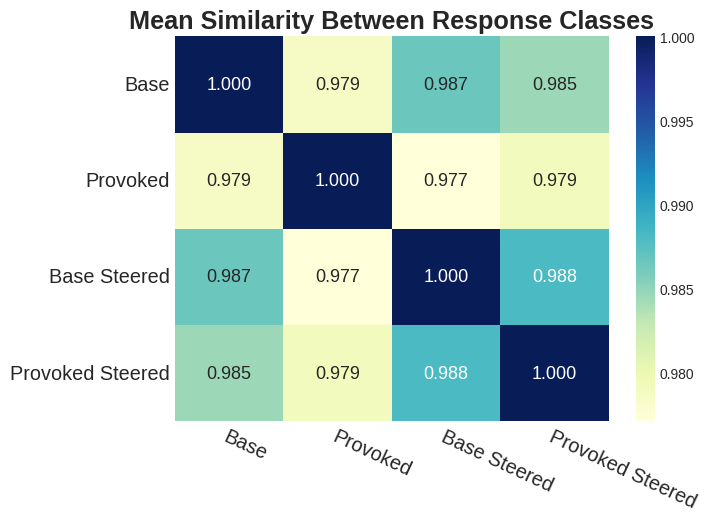

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import numpy as np
from sentence_transformers import SentenceTransformer


def visualize_embedding_analysis_single(base_responses, suggestive_responses, base_steered_responses, suggestive_steered_responses, variation_results, mean_pair_similarities, class_mean_similarities, which_plot="variation", font_size_multiplier=1.0):
    """
    Create a single visualization for text embedding analysis results.
    which_plot: one of ["variation", "heatmap", "mean_similarity", "pca"]
    font_size_multiplier: scale all font sizes by this factor
    Returns: fig
    """
    plt.style.use("seaborn-v0_8-whitegrid")
    sns.set_palette("deep")

    # Define base font sizes
    base_sizes = {
        'title': 14,
        'label': 12,
        'tick': 11,
        'legend': 11,
        'annot': 10
    }
    sizes = {k: v * font_size_multiplier for k, v in base_sizes.items()}

    if which_plot == "variation":
        fig, ax = plt.subplots(figsize=(7, 5))
        classes = list(variation_results.keys())
        variation_scores = [variation_results[cls]['variation_score'] for cls in classes]
        bars = ax.bar(classes, variation_scores, color=sns.color_palette("deep", 4))
        ax.set_title('Variation Within Response Classes', fontsize=sizes['title'], fontweight='bold')
        ax.set_ylabel('Variation Score (1 - mean similarity)', fontsize=sizes['label'])
        ax.set_ylim(0, max(variation_scores) * 1.2)
        ax.tick_params(axis='x', labelsize=sizes['tick'])
        ax.tick_params(axis='y', labelsize=sizes['tick'])
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center', fontsize=sizes['annot'])
        return fig

    elif which_plot == "heatmap":
        fig, ax = plt.subplots(figsize=(7, 5))
        class_list = ['Base', 'Provoked', 'Base Steered', 'Provoked Steered']
        sim_matrix = np.ones((4, 4))
        for i in range(len(class_list)):
            for j in range(i+1, len(class_list)):
                pair = f"{class_list[i]} vs {class_list[j]}"
                if pair in mean_pair_similarities:
                    sim_matrix[i, j] = mean_pair_similarities[pair]
                    sim_matrix[j, i] = mean_pair_similarities[pair]
        sns.heatmap(sim_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
                    xticklabels=class_list, yticklabels=class_list, ax=ax, annot_kws={"fontsize": sizes['annot']})
        ax.set_title('Mean Similarity Between Response Classes', fontsize=sizes['title'], fontweight='bold')
        ax.tick_params(axis='x', labelsize=sizes['tick'])
        ax.tick_params(axis='y', labelsize=sizes['tick'])
        plt.setp(ax.get_xticklabels(), rotation=-25, ha="left", rotation_mode="anchor")
        return fig

    elif which_plot == "mean_similarity":
        fig, ax = plt.subplots(figsize=(7, 5))
        classes = list(class_mean_similarities.keys())
        mean_sims = [class_mean_similarities[cls] for cls in classes]
        bars = ax.barh(classes, mean_sims, color=sns.color_palette("deep", 4))
        ax.set_title('Mean Similarity to Other Classes', fontsize=sizes['title'], fontweight='bold')
        ax.set_xlabel('Mean Similarity Score', fontsize=sizes['label'])
        ax.set_xlim(0, 1)
        ax.tick_params(axis='x', labelsize=sizes['tick'])
        ax.tick_params(axis='y', labelsize=sizes['tick'])
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2., f'{width:.3f}', ha='left', va='center', fontsize=sizes['annot'])
        return fig

    elif which_plot == "pca":
        fig, ax = plt.subplots(figsize=(8, 7))
        model = SentenceTransformer('all-MiniLM-L6-v2')
        base_emb = model.encode(base_responses)
        suggestive_emb = model.encode(suggestive_responses)
        base_steered_emb = model.encode(base_steered_responses)
        suggestive_steered_emb = model.encode(suggestive_steered_responses)
        all_embeddings = np.vstack([base_emb, suggestive_emb, base_steered_emb, suggestive_steered_emb])
        labels = ['Base'] * len(base_emb) + ['Provoked'] * len(suggestive_emb) + ['Base Steered'] * len(base_steered_emb) + ['Provoked Steered'] * len(suggestive_steered_emb)
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(all_embeddings)
        df = pd.DataFrame({'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'category': labels})
        for category, color in zip(['Base', 'Provoked', 'Base Steered', 'Provoked Steered'], sns.color_palette("deep", 4)):
            subset = df[df['category'] == category]
            ax.scatter(subset['x'], subset['y'], label=category, alpha=0.7, color=color)
        ax.set_title('PCA Visualization of Response Embeddings', fontsize=sizes['title'], fontweight='bold')
        ax.legend(fontsize=sizes['legend'], loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4)
        ax.set_xlabel('Principal Component 1', fontsize=sizes['label'])
        ax.set_ylabel('Principal Component 2', fontsize=sizes['label'])
        ax.tick_params(axis='x', labelsize=sizes['tick'])
        ax.tick_params(axis='y', labelsize=sizes['tick'])
        return fig
    elif which_plot == "tsne":
        # Use t-SNE instead of PCA for dimensionality reduction
        fig, ax = plt.subplots(figsize=(8, 7))
        model = SentenceTransformer('all-MiniLM-L6-v2')
        base_emb = model.encode(base_responses)
        suggestive_emb = model.encode(suggestive_responses)
        base_steered_emb = model.encode(base_steered_responses)
        suggestive_steered_emb = model.encode(suggestive_steered_responses)
        all_embeddings = np.vstack([base_emb, suggestive_emb, base_steered_emb, suggestive_steered_emb])
        labels = (
            ['Base'] * len(base_emb)
            + ['Provoked'] * len(suggestive_emb)
            + ['Base Steered'] * len(base_steered_emb)
            + ['Provoked Steered'] * len(suggestive_steered_emb)
        )
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        embeddings_2d = tsne.fit_transform(all_embeddings)
        df = pd.DataFrame({'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'category': labels})
        for category, color in zip(['Base', 'Provoked', 'Base Steered', 'Provoked Steered'], sns.color_palette("deep", 4)):
            subset = df[df['category'] == category]
            ax.scatter(subset['x'], subset['y'], label=category, alpha=0.7, color=color)
        ax.set_title('t-SNE Visualization of Response Embeddings', fontsize=sizes['title'], fontweight='bold')
        ax.legend(fontsize=sizes['legend'], loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4)
        ax.set_xlabel('t-SNE Dimension 1', fontsize=sizes['label'])
        ax.set_ylabel('t-SNE Dimension 2', fontsize=sizes['label'])
        ax.tick_params(axis='x', labelsize=sizes['tick'])
        ax.tick_params(axis='y', labelsize=sizes['tick'])
        return fig
    else:
        raise ValueError(f"Unknown plot type: {which_plot}")

# Example usage:
fig = visualize_embedding_analysis_single(base_responses, suggestive_responses, base_steered_responses,
                                           suggestive_steered_responses, variation_results, mean_pair_similarities, class_mean_similarities, which_plot="heatmap", font_size_multiplier=1.3)


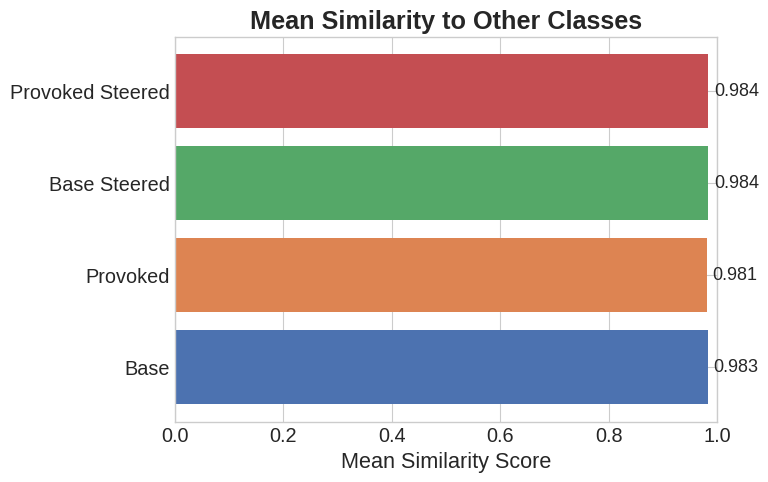

In [47]:

fig = visualize_embedding_analysis_single(base_responses, suggestive_responses, base_steered_responses,
                                           suggestive_steered_responses, variation_results, mean_pair_similarities, class_mean_similarities, which_plot="mean_similarity", font_size_multiplier=1.3)

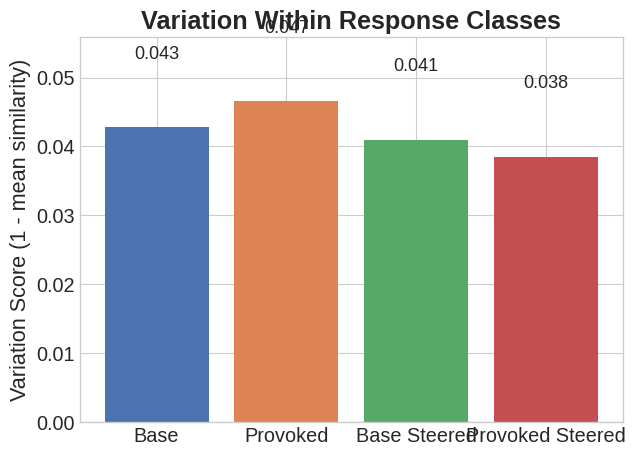

In [ ]:

fig = visualize_embedding_analysis_single(base_responses, suggestive_responses, base_steered_responses,
                                           suggestive_steered_responses, variation_results, mean_pair_similarities, class_mean_similarities, which_plot="variation", font_size_multiplier=1.3)

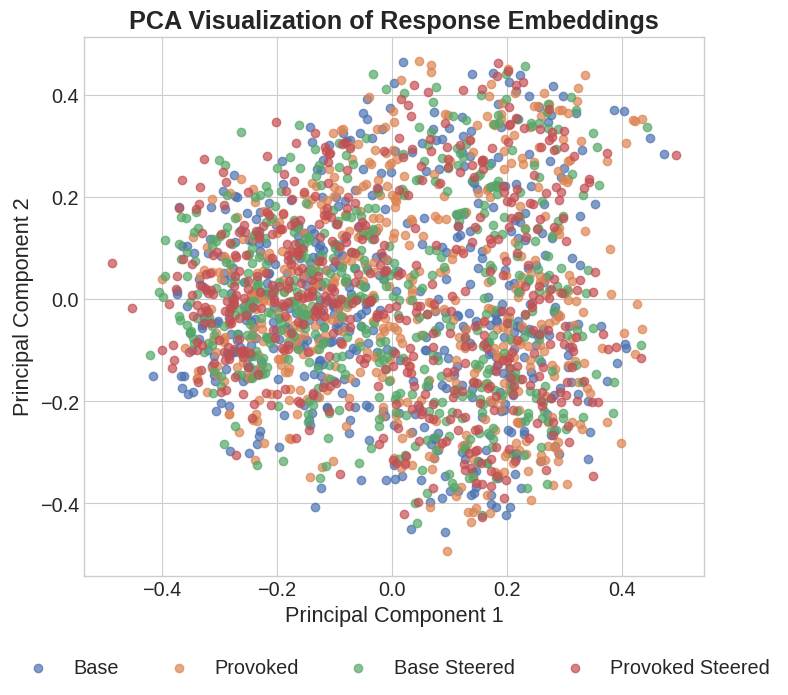

In [52]:

fig = visualize_embedding_analysis_single(base_responses, suggestive_responses, base_steered_responses,
                                           suggestive_steered_responses, variation_results, mean_pair_similarities, class_mean_similarities, which_plot="pca", font_size_multiplier=1.3)

In [ ]:

fig = visualize_embedding_analysis_single(base_responses, suggestive_responses, base_steered_responses,
                                           suggestive_steered_responses, variation_results, mean_pair_similarities, class_mean_similarities, which_plot="tsne", font_size_multiplier=1.3)